In [2]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../../astro_codes/')

In [3]:
# Load the *sparcfire* data
import pandas as pd
sparcfire_r = Table.read('../../sparcfire_directories/r/r.galaxy_matched.fits')
sparcfire_r_arcs = pd.read_csv('../../sparcfire_directories/r/r.galaxy_arcs.csv')

#### First task: define the sample. How many galaxies do we have?

* Load the Spotter data
* Check the number of classifications

In [4]:
from combining_catalogues import match_ids, make_matched_catalogue

spotter_subjects = Table.read('../../SpiralSpotter/tables/spiral_spotter_sparcfire_subjects.fits')
spotter_data = Table.read('../../SpiralSpotter/tables/spiral_spotter_sparcfire_data.fits')

matched_rows = match_ids(spotter_subjects,spotter_data,
                         'subject_id','subject_id')

matched_data = make_matched_catalogue(spotter_subjects,spotter_data,
                                      matched_rows)

matched_data['dr7id'] = spotter_subjects['dr7objid']
matched_data['dr8id'] = spotter_subjects['dr8objid']
matched_data.write('spotter_subjects_matched.fits',overwrite=True)
spotter_data = matched_data.copy()

500 galaxies in the reference catalogue
468 galaxies in the match catalogue
---> 457 matches in total


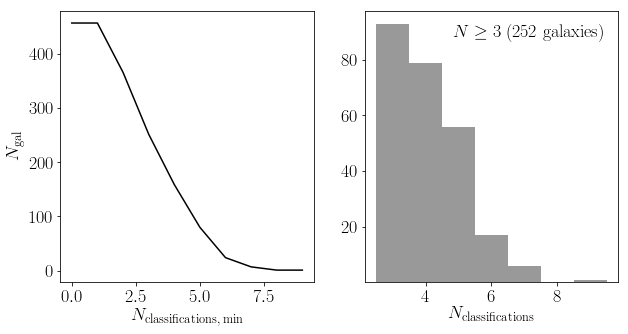

In [5]:
N_ok = []
N_classifications = []

for N in range(10):
    N_ok.append((spotter_data['total'] >= N).sum())
    N_classifications.append(N)

fig, axarr = plt.subplots(1,2,figsize=(10,5))
plt.sca(axarr[0])
_ = plt.plot(N_classifications,N_ok,color='k')
_ = plt.xlabel('$N_\mathrm{classifications, \, min}$')
_ = plt.ylabel('$N_\mathrm{gal}$')

class_ok = spotter_data['total'] >= 3
plt.sca(axarr[1])
_ = plt.hist(spotter_data['total'][class_ok],bins=np.linspace(2.5,9.5,8),
             color='k',alpha=0.4)
_ = plt.xlabel('$N_\mathrm{classifications}$')
_ = plt.text(0.95,0.95,'$N \geq{}$ ({} galaxies)'.format(3,class_ok.sum()),
             transform=axarr[1].transAxes,ha='right',va='top')

spotted_ids = spotter_data['dr8id'][class_ok]
spotter_data['class_ok'] = class_ok

We have 252 galaxies that have been classified with >= 3 votes. We will now do all of our training on this subset of galaxies.

--> **Now, we match up the _p_ scores to their individual arc metadata.**

In [6]:
from arc_data import ArcData, ParamikoClient

arc_tables = []
for id_ in spotted_ids:
    arc_tables.append(ArcData(id_).arc_parameters(sparcfire_r_arcs,
                                                   sparcfire_r))
    
arc_table_spotted = vstack(arc_tables)

In [7]:
def match_arc_scores(arc_table,galaxy_table,
                     arc_id='gxyName',galaxy_id='dr8id'):
    labels = ('good','poor','weak','extension','junk','missing')
    ids = np.unique(arc_table['gxyName'])
    N_arc_rows = len(arc_table)
    for label in labels:
        arc_table['p_{}'.format(label)] = np.zeros(N_arc_rows,
                                                   dtype=np.float16)
    for id_ in ids: 
        masked_arc_rows = arc_table[arc_id] == id_
        masked_galaxy_row = galaxy_table[galaxy_id] == id_
        arc_rows = arc_table[masked_arc_rows]
        galaxy_row = galaxy_table[masked_galaxy_row]
        N_arcs = masked_arc_rows.sum()
        for label in labels:
            column_values = []
            for n in range(N_arcs):
                column_name = 'arc{}_{}_frac'.format(n+1,label)
                arc_column_name = 'p_{}'.format(label)
                column_values.append(galaxy_row[column_name][0])
            arc_table[arc_column_name][masked_arc_rows] = column_values
            
    return arc_table

arc_table_spotted = match_arc_scores(arc_table_spotted,spotter_data)
# ^ this table is a table of 'spotted' galaxies with their corresponding 
# arc p-values from SpiralSpotter

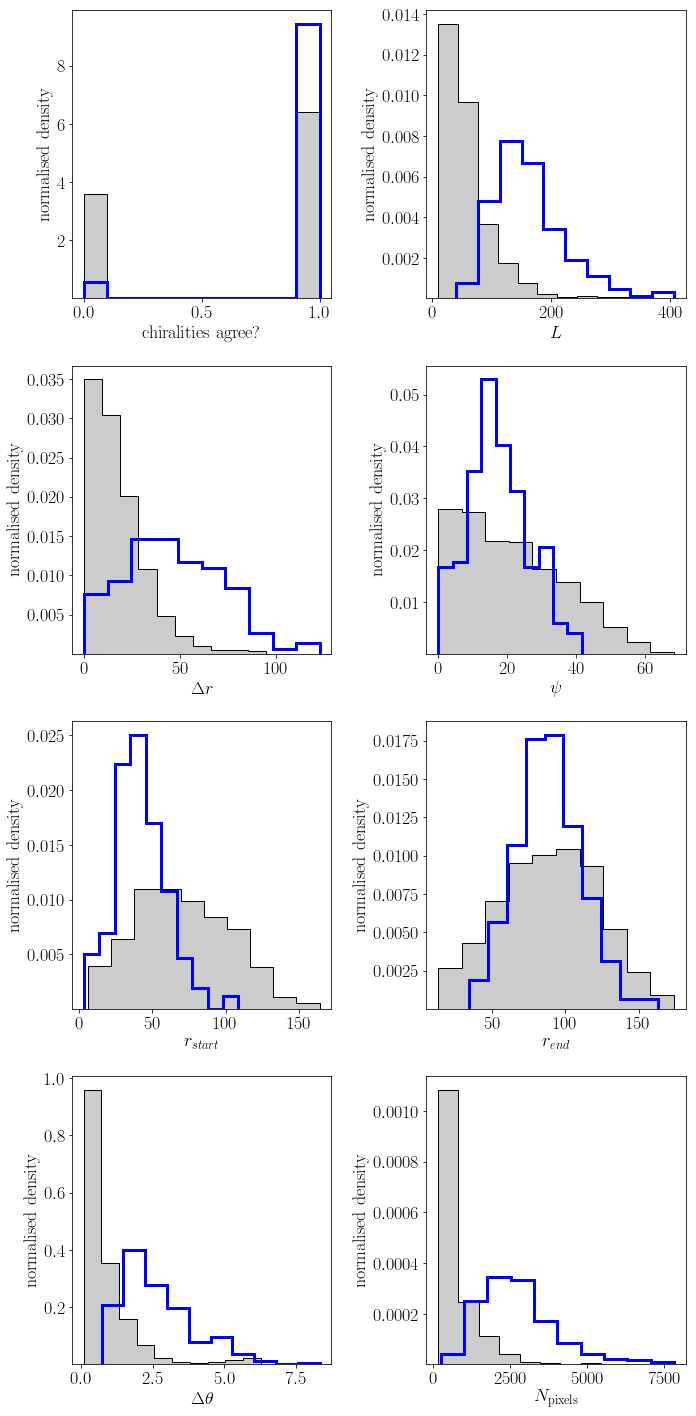

In [8]:
def arc_histogram(ax,data,bins,variable_column,feature_column,
                  p=0.5,p_type='threshold',label='good',xlabel='$L$',
                  color='r',reference=True):
    if p_type is 'threshold':
        good_rows = data[feature_column] >= p
    else:
        good_rows = data[feature_column] == p
    bad_rows = good_rows == False
    good_label = '$p_\mathrm{{{}}}>{} \, (N_\mathrm{{arcs}}={})$'.format(label,p,
                                                           good_rows.sum())
    bad_label = '$p_\mathrm{{{}}}\leq{} \, (N_\mathrm{{arcs}}={})$'.format(label,p,
                                                             bad_rows.sum())
    if reference is True:
        _ = ax.hist(data[variable_column][bad_rows],bins,normed=True,
                    color='k',alpha=0.2,label=bad_label)
        _ = ax.hist(data[variable_column][bad_rows],bins,normed=True,
                    histtype='step',color='k')
    _ = ax.hist(data[variable_column][good_rows],bins,normed=True,
                histtype='step',color=color,lw=3,label=good_label)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel('normalised density')
    #_ = ax.legend(fontsize=15)
    return ax

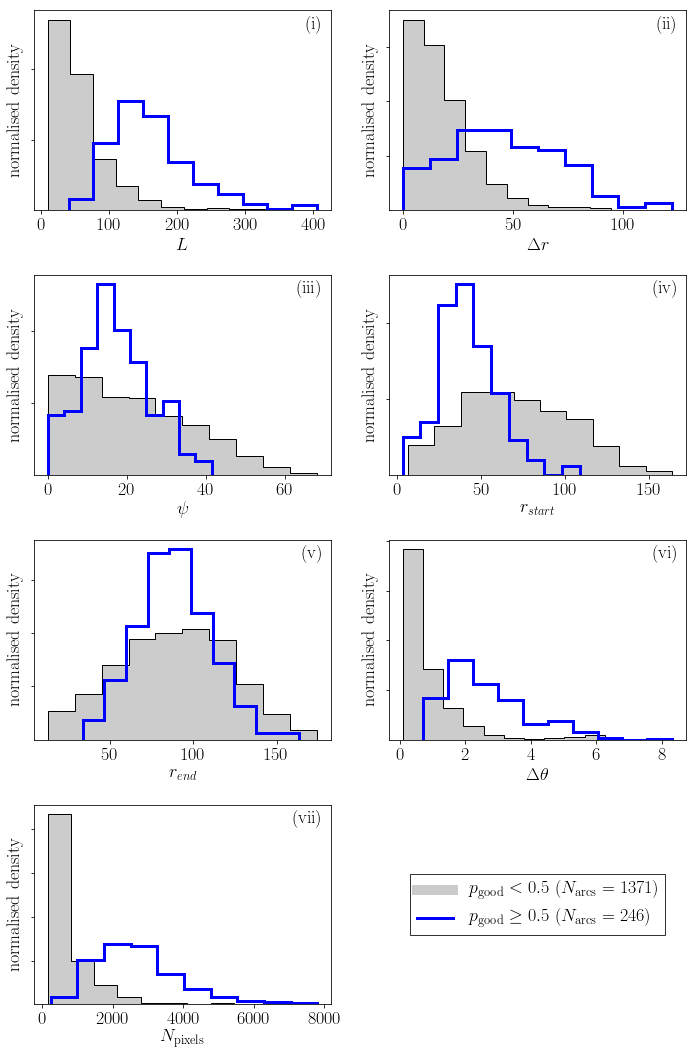

In [30]:
# Paper figure!

arc_params = ('arc_length','delta_r',
              'pitch_angle_absolute','r_start','r_end',
              'relative_theta_end','num_pixels')
xlabel_list = ('$L$','$\Delta r$','$\psi$',
               '$r_{start}$','$r_{end}$',r'$\Delta \theta$',
               '$N_\mathrm{pixels}$')

fig, axarr = plt.subplots(4,2,figsize=(10,15))
axarr = axarr.ravel()
#fig.delaxes(axarr[-1])
numerals = ('i','ii','iii','iv','v','vi','vii','viii','ix','x')


for a, (arc_param, ax, xlabel, numeral) in enumerate(zip(arc_params,axarr,
                                                     xlabel_list,numerals)):

    ax = arc_histogram(ax,arc_table_spotted,None,arc_param,'p_good',
                       xlabel=xlabel,color='b')
    
    ax.text(0.975,0.975,'({})'.format(numeral),
            transform=ax.transAxes,ha='right',va='top')
    
    _ = ax.set_yticklabels([])
    #_ = ax.set_ylabel()
    
fig.tight_layout()

plt.sca(axarr[-1])
plt.axis('off')
good_arcs = arc_table_spotted['p_good'] >= 0.5
bad_arcs = good_arcs == False
_ = axarr[-1].plot([],[],color='k',alpha=0.2,lw=10,
        label='$p_\mathrm{{good}} < 0.5$ ($N_\mathrm{{arcs}}={}$)'.format(bad_arcs.sum()))
_ = axarr[-1].plot([],[],color='b',lw=3,
        label='$p_\mathrm{{good}} \geq 0.5$ ($N_\mathrm{{arcs}}={}$)'.format(good_arcs.sum()))
_ = axarr[-1].legend(edgecolor='k',fancybox=False,loc='center')



fig.savefig('../paper_figures/svm_histograms.pdf')

From an initial runthrough, we can see what the overall parameters are for our good and poor arcs. Generally, good arcs are:

- More likely to agree with the dominant chirality
- Longer
- Cover a wider radial distance
- Have pitch angles in the range 10 < $\psi$ < 30
- Start closer to the centre of the galaxy
- Wind round a greater distance (cover a bigger range of $\theta$)
- Be comprised of more pixels

#### Now: can we use the sklearn methods to tell us whether an arc is true or not?

Outr aim here is to use an ML method to train on all of these characteristics and pick out the best arcs. 

In [31]:
class Classifier():
    def __init__(self,clf,X,y):
        self.X_scaled = StandardScaler().fit_transform(X)
        self.X_train, self.X_test, self.y_train, self.y_test = \
         train_test_split(self.X_scaled,y,test_size=0.25,random_state=0)
        self.clf = clf
        
    def fit(self):
        clf.fit(self.X_train,self.y_train)
        self.y_probabilities = clf.predict_proba(self.X_test)
        self.y_classes = clf.predict(self.X_train)
        
    def ROC_curve(self,ax,plot=True,probs=np.linspace(0.1,0.9,17),**kwargs):
        tp_rates = []
        fp_rates = []
        for prob in probs:   
            y_predicted = self.y_probabilities[:,1] >= prob
            tp, fp = self.ROC_rates(y_predicted,self.y_test)
            tp_rates.append(tp)
            fp_rates.append(fp)
        if plot is True:
            ax.plot(fp_rates,tp_rates,**kwargs)
            ax.set_xlabel('fp rate')
            ax.set_ylabel('tp rate')
        rates_table = Table(np.array([probs,tp_rates,fp_rates]).T,
                            names=('p','tp_rate','fp_rate'))
        return rates_table
        
    def ROC_rates(self,y_predicted,y_true):
        true_positive = y_true == 1
        true_negative = y_true == 0 
        predicted_positive = y_predicted == 1
        predicted_negative = y_predicted == 0
        tp_rate = (true_positive*predicted_positive).sum()/predicted_positive.sum()
        fp_rate = (true_positive*predicted_negative).sum()/predicted_negative.sum()
        return tp_rate, fp_rate
    
    def CC_curve(self,ax,plot=True,probs=np.linspace(0.1,0.9,17),
                                            **kwargs):
        completenesses = []
        contaminations = []
        for prob in probs:   
            y_predicted = self.y_probabilities[:,1] >= prob
            completeness, contamination = completeness_contamination(y_predicted,self.y_test)
            completenesses.append(completeness)
            contaminations.append(contamination)
        efficiencies = [1-c for c in contaminations]
        if plot is True:
            ax.plot(efficiencies,completenesses,**kwargs)
            ax.set_xlabel('efficiency')
            ax.set_ylabel('completeness')
        rates_table = Table(np.array([probs,completenesses,contaminations]).T,
                            names=('p','completeness','efficiency'))
        return rates_table

In [32]:
# Load the relevant classifiers
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

mlp_parameters = {'alpha':[0.01,0.1,1,10]}
svc_parameters =  {'gamma':[0.01,0.1,1,10],'C':[0.01,0.1,1,10]}
kn_parameters = {'weights':['uniform','distance'],'p':[1,2]}

classifiers = [GridSearchCV(MLPClassifier(random_state=0),
                            mlp_parameters),
               GaussianNB(),
               GridSearchCV(SVC(random_state=0,probability=True),
                            svc_parameters),
               GridSearchCV(KNeighborsClassifier(),
                            kn_parameters),
               #GaussianProcessClassifier(random_state=0)
               ]

In [33]:
from astroML.utils import completeness_contamination
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
    
class ArcTable():
    def __init__(self,table):
        self.table = table
        self.arc_params = ('arc_length','delta_r','pitch_angle_absolute',
                           'r_start','r_end','relative_theta_end',
                           'num_pixels')
        
    def as_array(self,scaled=True,scaler=None):
        X = np.array([self.table[a] for a in self.arc_params]
                     ,dtype='float64').T
        y = np.array(self.table['p_good'] >= 0.5)#[:,np.newaxis]
        chi_mask = self.table['chirality_agreement']
        if scaled is True:
            X = self.scale(X,scaler)
        return X, y, chi_mask
    
    def scale(self,X,X_scaler=None):
        if X_scaler is None:
            X_scaled = StandardScaler().fit_transform(X)
            return X_scaled
        else:
            scaler_mean = np.mean(X_scaler,axis=0)
            scaler_std = np.std(X_scaler,axis=0)
            X_scaled = (X - scaler_mean)/scaler_std
            return X_scaled
        
    def galaxy_split(self,X,y,chi_mask,test_size=52,random_state=0):
        ids = self.table['gxyName']
        unique_ids = np.unique(ids)
        train_ids, test_ids = train_test_split(unique_ids,
                                test_size=test_size,random_state=random_state)
        
        class SplitObject():
            def __init__(self,X,y,chi_mask,ids,train_ids,test_ids):
                self.train_mask = np.any([ids == id_ for id_ in train_ids],
                                         axis=0)
                self.test_mask = np.any([ids == id_ for id_ in test_ids],
                                        axis=0)
                self.X_train = X[self.train_mask]
                self.X_test = X[self.test_mask]
                self.y_train = y[self.train_mask]
                self.y_test = y[self.test_mask]
                self.chi_mask_train = chi_mask[self.train_mask]
                self.chi_mask_test = chi_mask[self.test_mask]
                self.arc_train_ids = ids[self.train_mask] 
                self.arc_test_ids = ids[self.test_mask]
                self.train_ids = train_ids
                self.test_ids = test_ids
                
        return SplitObject(X,y,chi_mask,ids,train_ids,test_ids)
    

class ClassifyXy():
    
    def __init__(self,Xy_split):
        ClassifyXy.Xy_split = Xy_split
        
    def fit_and_test_classifier(self,classifier,Xy_split,chi_mask=False):
        classifier.fit(Xy_split.X_train,Xy_split.y_train)
        y_predicted = classifier.predict(Xy_split.X_test)
        if chi_mask is True:
            y_predicted[self.Xy_split.chi_mask_test ==  False] = 0
        completeness, contamination = completeness_contamination(y_predicted,
                                                             Xy_split.y_test)
        return completeness, contamination, classifier

    def fit_by_n(self,classifier,ax=None,chi_mask=False,
                 ticklabels=('$L$','$\Delta r$','$\psi$',
                             '$r_{start}$','$r_{end}$',
                             r'$\Delta \theta$','$N_\mathrm{pixels}$'),
                 linestyle='-'):
        _ , N_columns = np.shape(self.Xy_split.X_train)
        completenesses = []
        contaminations = []
        N_params = []
        for n in range(N_columns):
            Xy_split_n = copy.copy(self.Xy_split)
            Xy_split_n.X_train = self.Xy_split.X_train[:,:n+1]
            Xy_split_n.X_test = self.Xy_split.X_test[:,:n+1]
            completeness, contamination, _ = self.fit_and_test_classifier(classifier,
                                                                 Xy_split_n,chi_mask)
            completenesses.append(completeness)
            contaminations.append(contamination)
            N_params.append(n+1)
        if ax is not None:
            ax.plot(completenesses,'bo-',lw=1,linestyle=linestyle)
            ax.plot(contaminations,'rs-',lw=3,linestyle=linestyle)
            ax.set_xticks(np.arange(N_columns))
            ax.set_xticklabels(ticklabels)
            ax.set_xlim(-1,N_columns)
            ax.set_ylim(0,1)
            #ax.legend(fontsize=15,fancybox=False,edgecolor='k')
        
        output_table = Table(np.array([N_params,completenesses,contaminations]).T,
                             names=('N_params','completeness','contamination'))
        return output_table

    def fit_by_Narcs(self,classifier,ax=None,N_splits=4,chi_mask=False,
                     linestyle='-'):
        N_rows, _ = np.shape(Xy_split.X_train)
        N_arcs = np.linspace(0,N_rows,N_splits+1)
        N_arcs = N_arcs[1:].astype(int)
        completenesses = []
        contaminations = []
        for n in N_arcs:
            Xy_split_n = copy.copy(self.Xy_split)
            Xy_split_n.X_train = self.Xy_split.X_train[:n,:]
            Xy_split_n.y_train = self.Xy_split.y_train[:n]
            completeness, contamination, _ = self.fit_and_test_classifier(classifier,
                                                                 Xy_split_n,chi_mask)
            completenesses.append(completeness)
            contaminations.append(contamination)
        if ax is not None:
            ax.plot(N_arcs,completenesses,'bo-',lw=1,linestyle=linestyle)
            ax.plot(N_arcs,contaminations,'rs-',lw=3,linestyle=linestyle)
            ax.set_ylim(0,1)
            #ax.legend(fontsize=15,fancybox=False,edgecolor='k')
        
        output_table = Table(np.array([N_arcs,completenesses,contaminations]).T,
                             names=('N_arcs','completeness','contamination'))
        return output_table
    
    def fit_by_Ngals(self,classifier,ax=None,N_splits=4,chi_mask=False,
                     linestyle='-'):
        arc_ids = Xy_split.arc_train_ids
        unique_ids = np.unique(arc_ids)
        np.random.seed(0)
        np.random.shuffle(unique_ids)
        N_gal = len(unique_ids)
        N_gals = np.linspace(0,N_gal,N_splits+1)
        N_gals = N_gals[1:].astype(int)
        completenesses = []
        contaminations = []
        for n in N_gals:
            ids_n = unique_ids[:n]
            id_mask = np.any([arc_ids == id_ for id_ in ids_n],axis=0)
            Xy_split_n = copy.copy(self.Xy_split)
            Xy_split_n.X_train = self.Xy_split.X_train[id_mask]
            Xy_split_n.y_train = self.Xy_split.y_train[id_mask]
            completeness, contamination, _ = self.fit_and_test_classifier(classifier,
                                                                 Xy_split_n,chi_mask)
            completenesses.append(completeness)
            contaminations.append(contamination)
        if ax is not None:
            ax.plot(N_gals,completenesses,'bo-',lw=1,linestyle=linestyle)
            ax.plot(N_gals,contaminations,'rs-',lw=3,linestyle=linestyle)
            ax.set_ylim(0,1)
            #ax.legend(fontsize=15,fancybox=False,edgecolor='k')
        
        output_table = Table(np.array([N_gals,completenesses,contaminations]).T,
                             names=('N_gals','completeness','contamination'))
        return output_table

/home/ppxrh/anaconda3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/ppxrh/anaconda3/lib/py

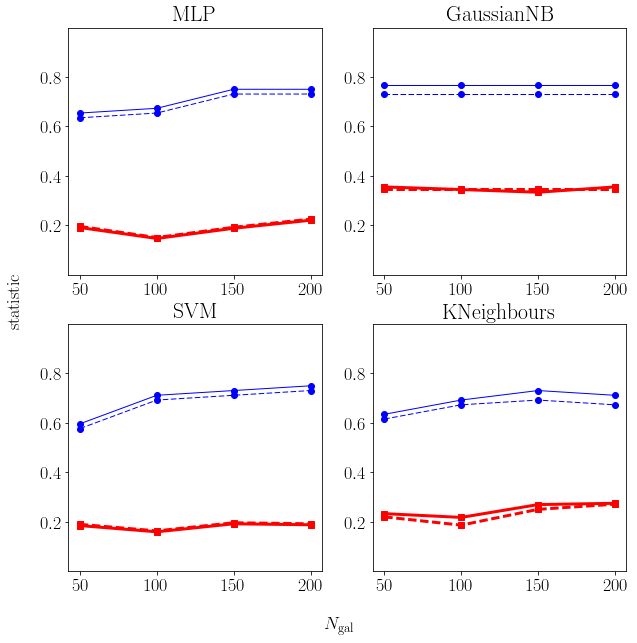

In [34]:
X, y, chi_mask = ArcTable(arc_table_spotted).as_array()
Xy_split = ArcTable(arc_table_spotted).galaxy_split(X,y,chi_mask,
                                                    random_state=2)
# hmm, the random state really does seem to be quite critical here...

figlabels = ('MLP','GaussianNB','SVM','KNeighbours')
fig, axarr = plt.subplots(2,2,figsize=(10,10))
axarr = axarr.ravel()

for ax, clf, figlabel in zip(axarr,classifiers,figlabels):
    _ = ClassifyXy(Xy_split).fit_by_Ngals(clf,ax,chi_mask=False)
    _ = ClassifyXy(Xy_split).fit_by_Ngals(clf,ax,chi_mask=True,linestyle='--')
    ax.set_title(figlabel)
    
fig.text(0.5, 0.04, '$N_\mathrm{gal}$', ha='center')
fig.text(0.04, 0.5, 'statistic', va='center', rotation='vertical')
axarr[-1].plot([],[],'bo-',label='completeness')
axarr[-1].plot([],[],'rs-',lw=3,label='contamination')

# solid line = all chiralities
# dashed line = dominant chirality only

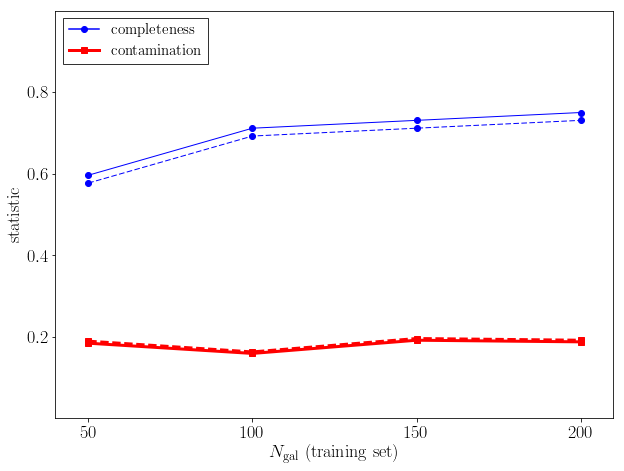

In [44]:
# Paper figure!
X, y, chi_mask = ArcTable(arc_table_spotted).as_array()
Xy_split = ArcTable(arc_table_spotted).galaxy_split(X,y,chi_mask,
                                                    random_state=2)

clf = classifiers[2]

fig = plt.figure(figsize=(10,7.5))
ax = plt.subplot(111)

_ = ClassifyXy(Xy_split).fit_by_Ngals(clf,ax,chi_mask=False)
_ = ClassifyXy(Xy_split).fit_by_Ngals(clf,ax,chi_mask=True,linestyle='--')

_ = ax.set_ylabel('statistic')
_ = ax.set_xlabel('$N_\mathrm{gal}$ (training set)')
_ = ax.set_xticks([50,100,150,200])
_ = ax.set_xlim(40,210)

_ = ax.plot([],[],'bo-',label='completeness')
_ = ax.plot([],[],'rs-',lw=3,label='contamination')
_ = ax.legend(loc='upper left',fancybox=False,edgecolor='k',fontsize=15)

fig.savefig('../paper_figures/svm_performance.pdf')

#### Now see what the classifier does to a normal subset of galaxies:

- Make a plot of true +ve, false +ve, true -ve and false -ve to see where the module is doing well/poorly?

First stage here is to fit the model and look at the fractions of fals +ves, false -ves, true +ves and true -ves.

In [12]:
best_clf = GridSearchCV(SVC(random_state=0,probability=True),
                        svc_parameters)
# ^Deemed to be the ~tied best classifier according to the ROC+CC analysis

_, _, best_clf = ClassifyXy(Xy_split).fit_and_test_classifier(best_clf,
                                                         Xy_split,False)

cc_ = ClassifyXy(Xy_split).fit_by_Ngals(best_clf,None,chi_mask=False)
cc_chi = ClassifyXy(Xy_split).fit_by_Ngals(best_clf,None,chi_mask=True)

202/1617 good arcs predicted!


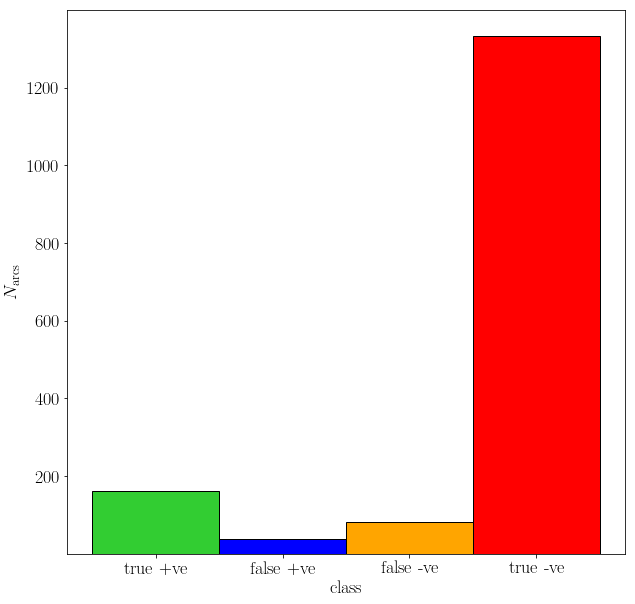

In [13]:
y_predicted = best_clf.predict(X)
y_predicted[chi_mask == False] = 0
arc_table_spotted['p_good_model'] = y_predicted

# Now create 'labels' for each of the classifications
real_positive = arc_table_spotted['p_good'] >= 0.5
real_negative = arc_table_spotted['p_good'] < 0.5
predicted_positive = arc_table_spotted['p_good_model'] == 1
predicted_negative = arc_table_spotted['p_good_model'] == 0

model_labels = np.zeros(len(arc_table_spotted))
model_labels[(predicted_positive*real_positive).astype(bool)] = 1 # true +ve
model_labels[(predicted_positive*real_negative).astype(bool)] = 2 # false +ve
model_labels[(predicted_negative*real_positive).astype(bool)] = 3 # false -ve
model_labels[(predicted_negative*real_negative).astype(bool)] = 4 # true -ve
arc_table_spotted['model_labels'] = model_labels

print('{}/{} good arcs predicted!'.format(y_predicted.sum(),
                                          len(y_predicted)))

#######################################
figure = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

bins = np.linspace(0.5,4.5,5)
_, _ , patches = plt.hist(model_labels,bins)
colors = ('limegreen','b','orange','r')
for i in range(len(patches)):
    patches[i].set_facecolor(colors[i])
    patches[i].set_linewidth(1)
    patches[i].set_edgecolor('k')

xlabels = ('true +ve','false +ve','false -ve','true -ve')
_ = ax.set_xticks([1,2,3,4])
_ = ax.set_xticklabels(xlabels)
_ = ax.set_xlabel('class')
_ = ax.set_ylabel('$N_\mathrm{arcs}$')
########################################

In [14]:
from tabulate import tabulate

headers = ('Category','$N_mathrm{arcs}$')

column0 = ['All','True positive','False positive',
           'False negative','True negative']

column1 = [len(arc_table_spotted)]
for n in range(4):
    column1.append(np.sum(arc_table_spotted['model_labels'] == n+1))

column_array = np.array([column0,column1],dtype=np.str).T

#print(tabulate(column_array,headers,tablefmt='fancy_grid'))
#print(tabulate(column_array,headers,tablefmt='latex'))

#### Now for the images!

In [15]:
gz2_data = Table.read('../../fits/full_sample_debiased_w_low_z_mod.fits')
# Load the paramiko client i.o.t. get images
client = ParamikoClient()

In [16]:
has_good_arm = [] # only do galaxies where people said there was >= 1 good arm!

for id_ in spotted_ids:
    arc_frame_id = arc_table_spotted[arc_table_spotted['gxyName'] == id_]
    has_good_arm.append(np.any(arc_frame_id['p_good'] > 0.5))

spotter_data['has_good_arm'] = np.zeros(len(spotter_data))
spotter_data['has_good_arm'][class_ok] = has_good_arm

print('{}/{} galaxies have >1 good arms'.format(np.sum(has_good_arm),
                                                len(has_good_arm)))

def get_gz2_stats(id_,gz2_data):
    m_colnames = ['t11_arms_number_a31_1_debiased_rh',
                  't11_arms_number_a32_2_debiased_rh',
                  't11_arms_number_a33_3_debiased_rh',
                  't11_arms_number_a34_4_debiased_rh',
                  't11_arms_number_a36_more_than_4_debiased_rh']
    
    w_colnames = ['t10_arms_winding_a28_tight_debiased_rh',
                  't10_arms_winding_a29_medium_debiased_rh',
                  't10_arms_winding_a30_loose_debiased_rh']
    
    gz2_row = gz2_data[gz2_data['dr8objid'] == id_]
    m = np.argmax([gz2_row[c] for c in m_colnames]) + 1
    w = np.argmax([gz2_row[c] for c in w_colnames]) + 1
    return m, w

best_mask = spotter_data['has_good_arm'].astype(bool)
best_ids = spotter_data['dr8id'][best_mask]

m_list = []
w_list = []
for id_ in best_ids:
    m, w = get_gz2_stats(id_,gz2_data)
    m_list.append(m)
    w_list.append(w)

spotted_gz2_array = np.array([best_ids,m_list,w_list]).T
spotted_gz2_table = Table(spotted_gz2_array,names=('id','m','w'),
                          dtype=('int64','int','int'))

126/252 galaxies have >1 good arms


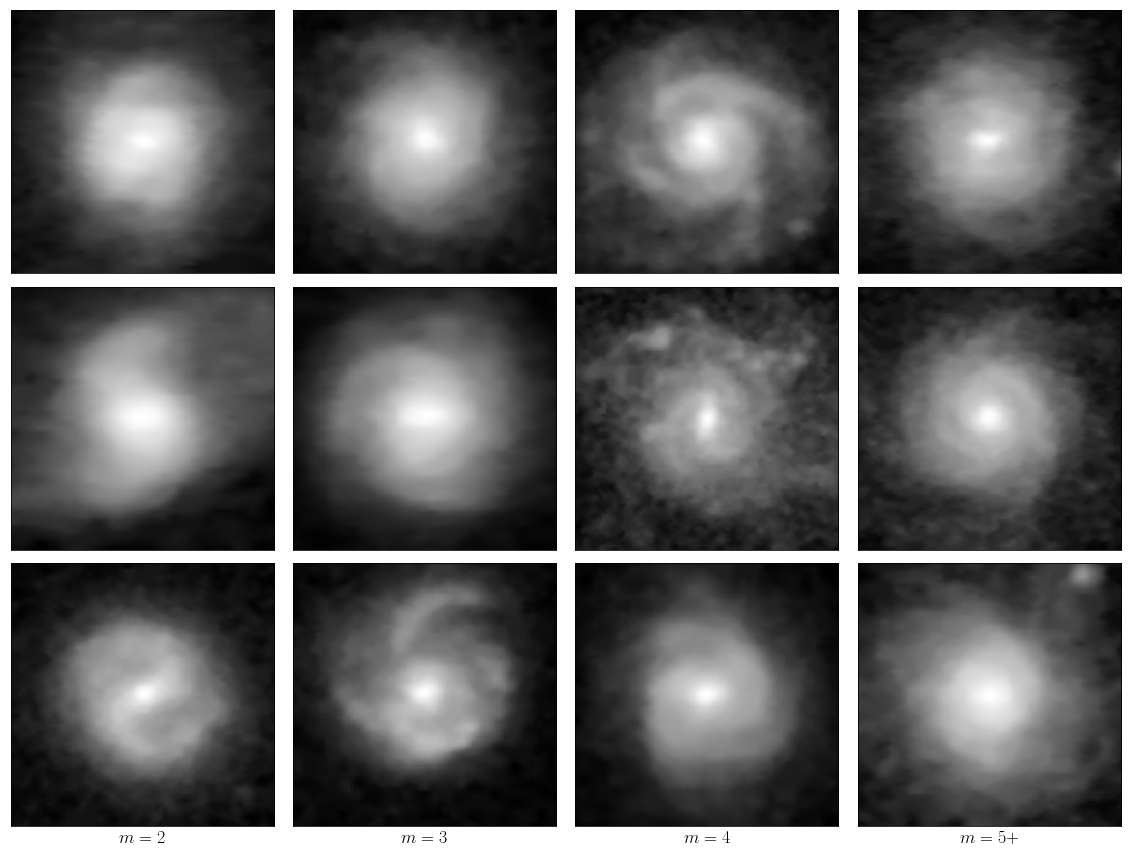

In [17]:
def colors_lookup(model_labels):
    colors_dictionary = {1:'limegreen',2:'b',3:'orange',4:'r'}
    colors_ = []
    for ml in model_labels:
        color_lookup = colors_dictionary[ml]
        colors_.append(color_lookup)
    return colors_

np.random.seed(0)
N_sample_galaxies = 3
plot_id_array = np.empty((N_sample_galaxies,4),dtype=np.int64)
for m in range(4):
    in_m = spotted_gz2_table['m'] == m+2
    m_ids = spotted_gz2_table['id'][in_m]
    random_ids = np.random.choice(m_ids,N_sample_galaxies,
                                  replace=False)
    plot_id_array[:,m] = random_ids
plot_ids = plot_id_array.ravel()

fig, axarr = plt.subplots(3,4,figsize=(20,15))
fig.subplots_adjust(hspace=0.05,wspace=0.05)

mlabels = ('1','2','3','4','5+')
for a, ax in enumerate(axarr[-1,:]):
    ax.set_xlabel('$m={}$'.format(mlabels[a+1]))
    
axarr = axarr.ravel()

# Raw images
for id_, ax in zip(plot_ids,axarr):
    arcplot = ArcData(id_)
    arcplot.display_image(ax,client=client)

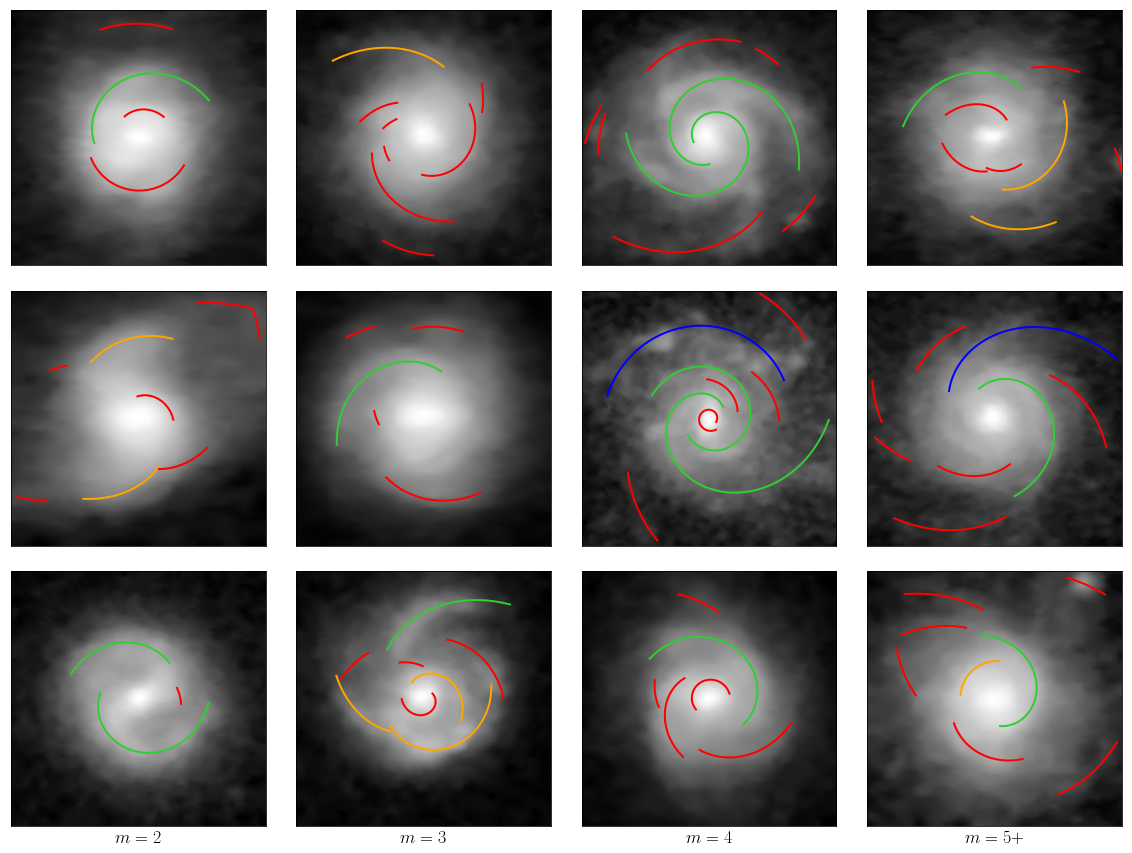

In [18]:
fig, axarr = plt.subplots(3,4,figsize=(20,15))
fig.subplots_adjust(wspace=0.1,hspace=0.1)

for a, ax in enumerate(axarr[-1,:]):
    ax.set_xlabel('$m={}$'.format(mlabels[a+1]))    
axarr = axarr.ravel()

for id_, ax in zip(plot_ids,axarr):
    arcplot = ArcData(id_)
    arc_classes = arc_table_spotted[arc_table_spotted['gxyName'] == id_]
    model_labels = np.array(arc_classes['model_labels'],dtype=np.int)
    colors = colors_lookup(model_labels)
    arcplot.display_image(ax,client=client)
    arcplot.draw_arcs(ax,sparcfire_r_arcs,sparcfire_r,
                      colors=colors,lw=2,label=False)
    
#fig.savefig('../paper_figures/spotted_arc_images.pdf')

#### Final task: we now want to use our trained classifier on our _full sample_ of galaxies

To save some time, I will run this on only the stellar mass complete sample of spirals. The output table is saved to "arc_table_ml.fits", which includes _all_ of the arcs for each of the galaxies, and then a binary column to measure whether arcs are good or not.

In [19]:
#samples = Table.read('../../fits/sparcfire/sparcfire_samples.fits')
ml_spirals_matched = Table.read('../fits/ml_table_matched.fits')

In [21]:
in_ml = ml_spirals_matched['vmax_ok']

print('{} spiral galaxies in the ML sample!'.format(in_ml.sum()))
has_dr8 = gz2_data['dr8objid'] >= 0
print('---> {} have DR8IDs!'.format((in_ml*has_dr8).sum()))
in_sparcfire = np.all([sparcfire_r['fit_state'] == 'OK',has_dr8],axis=0)
print('---> of which, {} were in sparcfire!'.format((in_ml*in_sparcfire).sum()))

ml_spirals_matched['in_sparcfire_r'] = in_sparcfire
ml_spirals_matched.write('../ml_table_matched.fits',overwrite=True)

6131 spiral galaxies in the ML sample!
---> 6037 have DR8IDs!
---> of which, 4727 were in sparcfire!


In [ ]:
ml_sparcfire = np.all([in_ml,in_sparcfire],axis=0)
ml_ids = gz2_data['dr8objid'][ml_sparcfire]

arc_tables_ml = []
for id_ in ml_ids:
    arc_tables_ml.append(ArcData(id_).arc_parameters(sparcfire_r_arcs,
                                                      sparcfire_r))
    
arc_table_ml = vstack(arc_tables_ml)

In [ ]:
arc_table_ml['p_good'] = np.zeros(len(arc_table_ml)) # dummy column!

scaler, _, _ = ArcTable(arc_table_spotted).as_array(scaled=False)
X_ml, y_ml, chi_mask_ML = ArcTable(arc_table_ml).as_array(scaler=scaler)

y_predicted = best_clf.predict(X_ml)
y_predicted[chi_mask_ML == False] = 0
print('Predicted {}/{} good arcs!'.format(y_predicted.sum(),
                                          len(y_predicted)))

arc_table_ml['p_good_predicted'] = y_predicted

In [ ]:
good_arcs = arc_table_ml['p_good_predicted'] == 1
good_galaxies = np.unique(arc_table_ml['gxyName'][good_arcs])
input_galaxies = np.unique(arc_table_ml['gxyName'])
print('{}/{} ({}%) galaxies have good arc measurements!'.format(len(good_galaxies),
                                                         len(input_galaxies),
            100*np.round(len(good_galaxies)/len(input_galaxies),decimals=3)))

In [ ]:
columns = arc_table_ml.colnames
dtypes = ('int64','int32','float32','float32','float32','float32',
          'float32','float32','float32','bool','bool','bool','float32',
          'float32','float32','float32','float32','float32','float32',
          np.str,'bool','float32','float32','float32','float32')

for column, dtype in zip(columns,dtypes):
    arc_table_ml[column] = arc_table_ml[column].astype(dtype)

arc_table_ml.write('../fits/arc_table_ml.fits',overwrite=True)

#### Do the same for _all_ spirals!

In [28]:
in_spiral = np.load('../fits/spiral_ok.npy')

all_ok = np.all([in_spiral,in_sparcfire],axis=0)
all_ids = gz2_data['dr8objid'][all_ok]

arc_tables_all = []
for id_ in all_ids:
    arc_tables_all.append(ArcData(id_).arc_parameters(sparcfire_r_arcs,
                                                      sparcfire_r))
    
arc_table_all = vstack(arc_tables_all)

In [30]:
arc_table_all['p_good'] = np.zeros(len(arc_table_all)) # dummy column!

scaler, _, _ = ArcTable(arc_table_spotted).as_array(scaled=False)
X_all, y_all, chi_mask_all = ArcTable(arc_table_all).as_array(scaler=scaler)

y_predicted = best_clf.predict(X_all)
y_predicted[chi_mask_all == False] = 0
print('Predicted {}/{} good arcs!'.format(y_predicted.sum(),
                                          len(y_predicted)))

arc_table_all['p_good_predicted'] = y_predicted

Predicted 24315/213769 good arcs!


In [31]:
columns = arc_table_all.colnames
dtypes = ('int64','int32','float32','float32','float32','float32',
          'float32','float32','float32','bool','bool','bool','float32',
          'float32','float32','float32','float32','float32','float32',
          np.str,'bool','float32','float32','float32','float32')

for column, dtype in zip(columns,dtypes):
    arc_table_all[column] = arc_table_all[column].astype(dtype)

arc_table_all.write('../fits/arc_table_all.fits',overwrite=True)